# Forecasting Molecule

In [81]:
pip install prophet


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [82]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\annap\appdata\local\programs\python\python312\lib\site-packages (2.2.3)




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
# from scipy.stats import ttest_rei
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet




## Preprocessing

In [84]:
df = pd.read_excel('../test_data_working_students.xlsx')
df.head()

,Record ID,year,month,MoleculeName,TradeName,ProductName,Packs,Value
0,1,2017,12,molecule1,brand1,SKU1,2966.0,32504.671461
1,2,2017,12,molecule2,brand2,SKU2,7675.0,5627.328111
2,3,2017,12,molecule2,brand2,SKU3,24404.0,10741.583225
3,4,2017,12,molecule3,brand3,SKU4,14775.0,65098.087341
4,5,2017,12,molecule3,brand3,SKU5,18206.0,61614.771981


In [85]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
# df.set_index('date', inplace=True)

target_col = "Value"
ts = df[target_col].dropna()

df['month_of_year'] = df['month']     
df['quarter'] = df['date'].dt.quarter  
df['week_of_year'] = df['date'].dt.isocalendar().week  


df['Value_Lag1']= df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Value'].shift(1)
df['Packs_Lag1']= df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Packs'].shift(1)     
  
df['Value_Rolling_3'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Value'].transform(lambda x: x.rolling(3).mean()) 
df['Packs_Rolling_3'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Packs'].transform(lambda x: x.rolling(3).mean())   
df['Value_Rolling_6'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Value'].transform(lambda x: x.rolling(6).mean()) 
df['Packs_Rolling_6'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Packs'].transform(lambda x: x.rolling(6).mean())    

#drop the nan values from lags/rolling transformations
# df.dropna(subset=['Value_Lag1', 'Packs_Lag1', 'Value_Rolling_3', 'Packs_Rolling_3', 'Value_Rolling_6', 'Packs_Rolling_6'], inplace=True)   
df.dropna(inplace=True)

 
encoder= OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df[['MoleculeName', 'TradeName', 'ProductName']])
df = df.reset_index(drop=True)
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['MoleculeName', 'TradeName', 'ProductName']))
df= pd.concat([df, encoded_df], axis=1)   


c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [115]:
df.head()

,Record ID,year,month,MoleculeName,TradeName,ProductName,Packs,Value,date,month_of_year,...,ProductName_SKU90,ProductName_SKU91,ProductName_SKU92,ProductName_SKU93,ProductName_SKU94,ProductName_SKU95,ProductName_SKU96,ProductName_SKU97,ProductName_SKU98,ProductName_SKU99
0,615,2018,5,molecule2,brand2,SKU2,7367.0,5326.093802,2018-05-01,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,616,2018,5,molecule2,brand2,SKU3,24724.0,10765.081285,2018-05-01,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,617,2018,5,molecule3,brand3,SKU4,19016.0,84260.433206,2018-05-01,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,618,2018,5,molecule3,brand3,SKU5,20125.0,68250.417966,2018-05-01,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,619,2018,5,molecule4,brand4,SKU6,748.0,4933.805989,2018-05-01,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
target_value = 'Value'
target_packs = 'Packs'  

features = ['date','year', 'month','month_of_year','quarter', 'week_of_year', 'Value_Lag1','Packs_Lag1','Value_Rolling_3', 'Packs_Rolling_3', 'Value_Rolling_6','Packs_Rolling_6'] + list(encoded_df.columns)   

X= df[features]   
y_value = df[target_value]  
y_packs = df[target_packs]        

tscv = TimeSeriesSplit(n_splits=5) 
scaler = StandardScaler()


## Models

In [138]:
def evaluate_model(model, X, y, tscv, param_grid=None):
    mse_scores = []   
    all_residuals = []
    best_model = None

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test= X.iloc[train_idx], X.iloc[test_idx] 
        y_train, y_test= y.iloc[train_idx], y.iloc[test_idx]    
    
        if isinstance(model, SARIMAX):
            # ts_train = y_train                                          #only use y_train as timeseries data
            # ts_test = y_test
            # sarima_model = SARIMAX(ts_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
            # sarima_fit = sarima_model.fit(disp=False)
            best_mse = float('inf') 

            for order in param_grid['order']:    
                for seasonal_order in param_grid['seasonal_order']:
                    sarima_model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order) 
                    sarima_fit = sarima_model.fit(disp=False)
                    forecast = sarima_fit.forecast(steps=len(y_test))
                    mse = mean_squared_error(y_test,forecast)   
                        
                    if mse < best_mse:
                        best_mse = mse
                        best_model= sarima_fit 

            y_pred = best_model.forecast(steps=len(y_test))
            residuals = y_test - y_pred  
            mse_scores.append(best_mse)
            all_residuals.append(pd.DataFrame({"y_test": y_test, "y_pred": y_pred, "residuals": residuals}))



        elif isinstance(model, Prophet): 
            best_mse = float('inf')

            for growth in param_grid['growth']:  
                for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
                    prophet_model = Prophet(growth=growth,changepoint_prior_scale=changepoint_prior_scale)  
                    train_data= pd.DataFrame({'ds': X_train['date'], 'y': y_train})
                    test_data = pd.DataFrame({'ds': X_test['date'], 'y': y_test})   
                     
                    prophet_model.fit(train_data)    
                    forecast = prophet_model.predict(test_data)
                    mse = mean_squared_error(y_test,forecast['yhat'])
                    
                    if mse < best_mse:
                        best_mse = mse
                        best_model = prophet_model    
                  
            y_pred = best_model.predict(test_data)['yhat'].values.flatten() 
            residuals = y_test.values- y_pred
            mse = mean_squared_error(y_test, y_pred)  
            all_residuals.append(pd.DataFrame({"y_test": y_test.values, "y_pred": y_pred, "residuals": residuals}))

            

        else: 
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            print(f"Training set size: {X_train_scaled.shape},  Test set size: {X_test_scaled.shape}")
                 
                   
            if param_grid is not None: 
                grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
                grid_search.fit(X_train_scaled, y_train)
                best_model = grid_search.best_estimator_
                print(f"Best parameters: {grid_search.best_params_}")
            else:
                best_model=model 
                best_model.fit(X_train_scaled, y_train)
              
                
            y_pred = best_model.predict(X_test_scaled)
            residuals = y_test - y_pred   
            mse = mean_squared_error(y_test, y_pred) 

        mse_scores.append(mse)  

        all_residuals.append(pd.DataFrame({"y_test": y_test,"y_pred": y_pred, "residuals": residuals}))  


    mean_mse = np.mean(mse_scores)    
    print(f'Mean MSE:  {mean_mse}')  

    return best_model, mean_mse, pd.concat(all_residuals)   



### Linear Regression

In [88]:
ts = ts.reset_index()
ts['time_index'] = np.arange(len(ts))
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]  


lin_reg = LinearRegression() 
lin_reg.fit(train[["time_index"]], train[target_col])
preds_lr = lin_reg.predict(test[["time_index"]])

mse_lr = mean_squared_error(test[target_col], preds_lr)    
print(f"Linear Regression MSE: {mse_lr}") 

Linear Regression MSE: 95503663576.30641


### ARIMA

In [89]:
arima_model = ARIMA(train[target_col], order=(1,1,1)).fit()
preds_arima = arima_model.forecast(len(test))

mse_arima = mean_squared_error(test[target_col], preds_arima)
print(f"ARIMA MSE: {mse_arima}")

ARIMA MSE: 93380648532.49261


### XGBoost

#### Value

In [ ]:
X['week_of_year'] = X['week_of_year'].astype('int32')
X = X.astype({col: 'int32' for col in X.select_dtypes(include='Int64').columns})

X.fillna(0, inplace=True)
non_numeric_cols = X.select_dtypes(exclude=['number']).columns


param_grid_xgboost = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0],
    # 'gamma': [0, 0.1],
    # 'reg_alpha': [0, 0.01],
    # 'reg_lambda': [0, 0.01],
    'min_child_weight': [1]
}
   

C:\Users\annap\AppData\Local\Temp\ipykernel_9268\1583512183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['week_of_year'] = X['week_of_year'].astype('int32')


In [91]:
xg_reg_value = xgb.XGBRegressor(objective='reg:squarederror', 
                                n_estimators=100, 
                                learning_rate=0.1, 
                                enable_categorical=False)
xgboost_model_value, xg_mse_value, xg_residuals_value = evaluate_model(xg_reg_value, X, y_value, tscv, param_grid_xgboost)
print(f'XGBoost MSE for Value: {xgboost_model_value}')

Training set size: (586, 247),  Test set size: (581, 247)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training set size: (1167, 247),  Test set size: (581, 247)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training set size: (1748, 247),  Test set size: (581, 247)
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training set size: (2329, 247),  Test set size: (581, 247)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training set size: (2910, 247),  Test set size: (581, 247)
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsampl

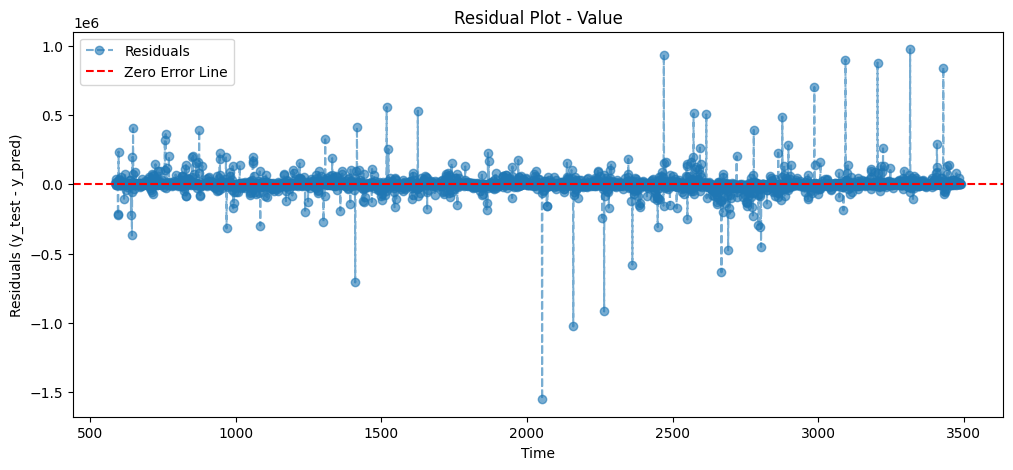

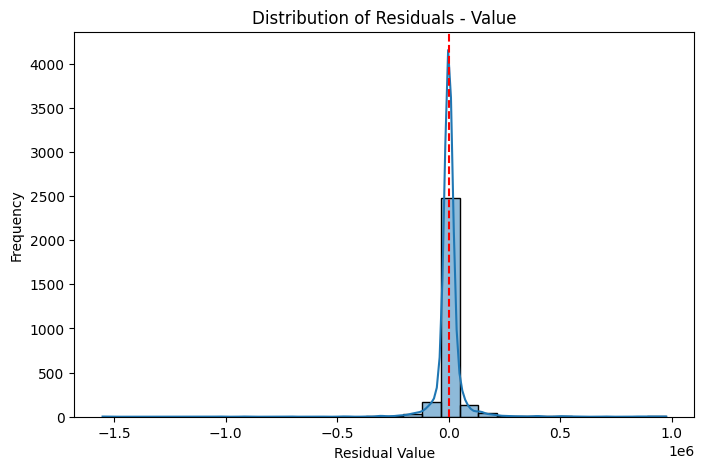

In [92]:
plt.figure(figsize=(12, 5))
plt.plot(xg_residuals_value.index, xg_residuals_value["residuals"], marker='o', linestyle='dashed', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot - Value")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(xg_residuals_value["residuals"], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals - Value")
plt.show()

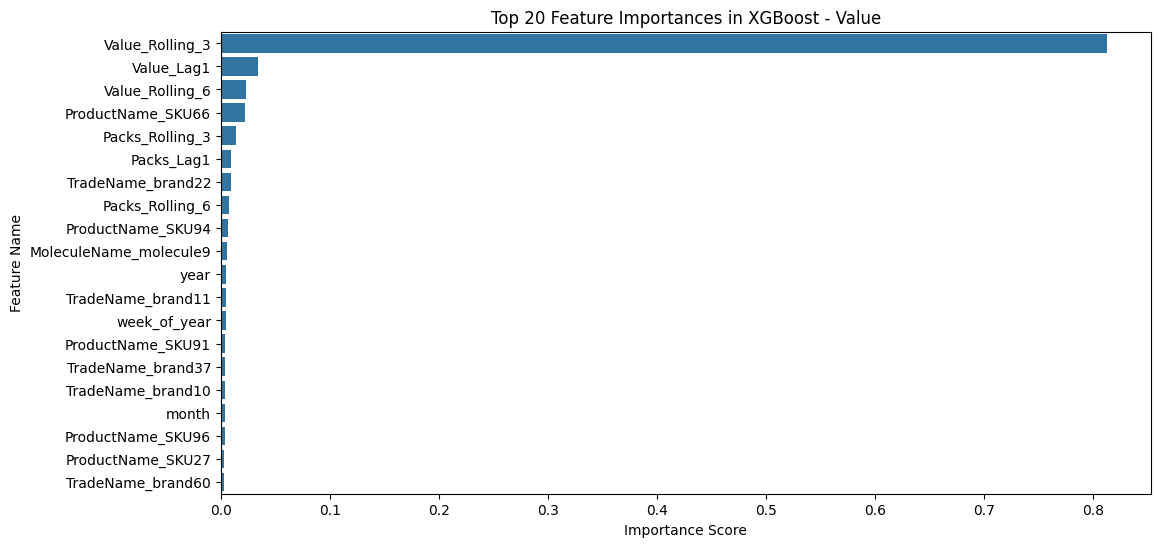

In [93]:
importances_value = xgboost_model_value.feature_importances_
feature_names = X.columns

feat_imp_df_value = pd.DataFrame({'Feature': feature_names, 'Importance': importances_value})
feat_imp_df_value = feat_imp_df_value.sort_values(by="Importance", ascending=False)  


plt.figure(figsize=(12, 6)) 
sns.barplot(x=feat_imp_df_value.Importance[:20], y=feat_imp_df_value.Feature[:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances in XGBoost - Value")  
plt.show()  
   

#### Packs

In [94]:
xg_reg_pack = xgb.XGBRegressor(objective='reg:squarederror', 
                                n_estimators=100, 
                                learning_rate=0.1, 
                                enable_categorical=False)
xgboost_model_pack, xg_mse_pack, xg_residuals_pack = evaluate_model(xg_reg_pack, X, y_packs, tscv, param_grid_xgboost)
print(f'XGBoost MSE for Pack: {xgboost_model_pack}')

Training set size: (586, 247),  Test set size: (581, 247)
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training set size: (1167, 247),  Test set size: (581, 247)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training set size: (1748, 247),  Test set size: (581, 247)
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training set size: (2329, 247),  Test set size: (581, 247)
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training set size: (2910, 247),  Test set size: (581, 247)
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsampl

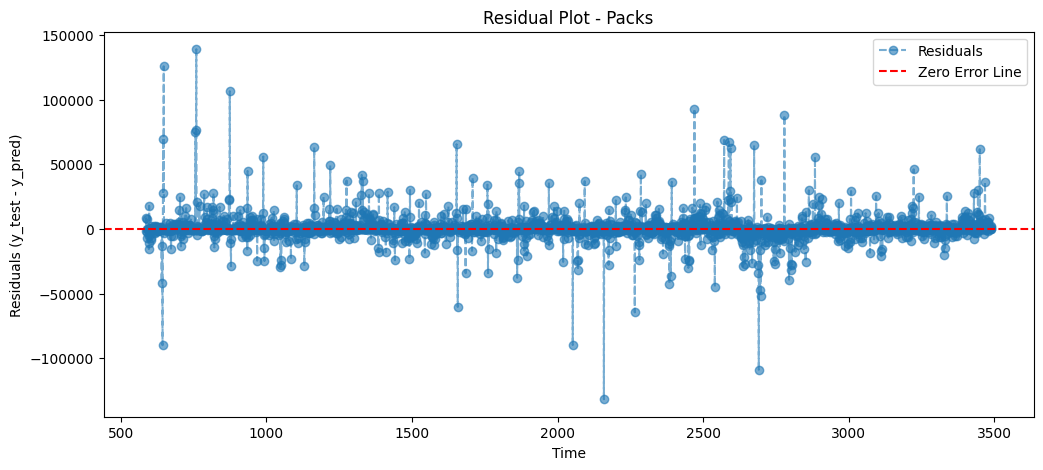

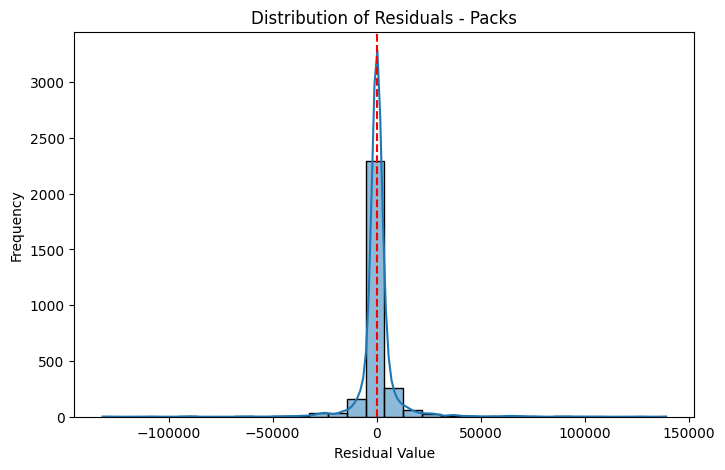

In [95]:
plt.figure(figsize=(12, 5))
plt.plot(xg_residuals_pack.index, xg_residuals_pack["residuals"], marker='o', linestyle='dashed', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot - Packs")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(xg_residuals_pack["residuals"], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")  
plt.title("Distribution of Residuals - Packs")
plt.show()

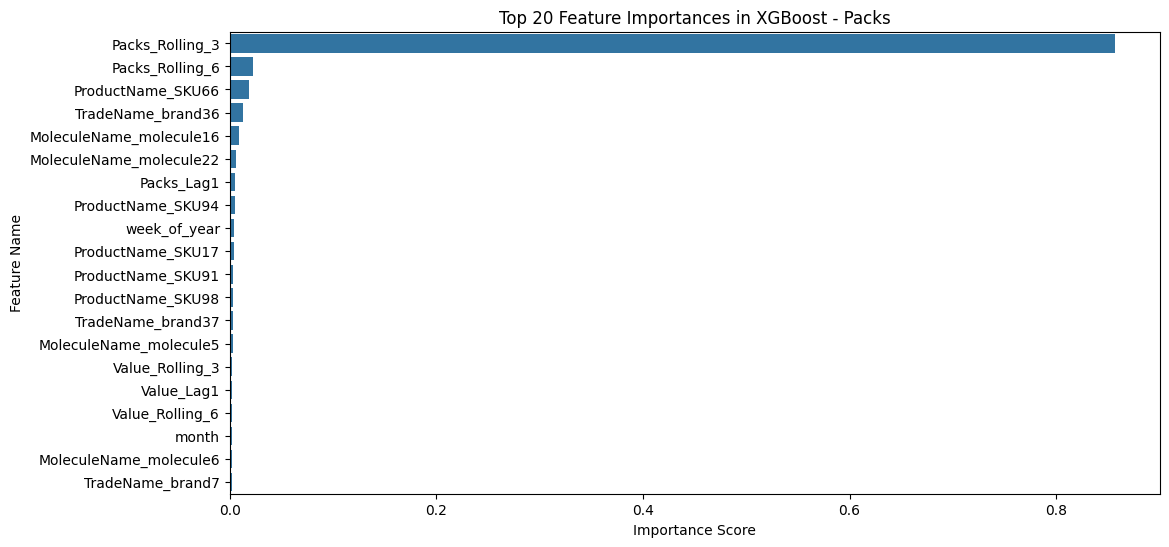

In [96]:
importances_packs = xgboost_model_pack.feature_importances_
feature_names = X.columns

feat_imp_df_packs = pd.DataFrame({'Feature': feature_names, 'Importance': importances_packs})
feat_imp_df_packs = feat_imp_df_packs.sort_values(by="Importance", ascending=False)  


plt.figure(figsize=(12, 6)) 
sns.barplot(x=feat_imp_df_packs.Importance[:20], y=feat_imp_df_packs.Feature[:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances in XGBoost - Packs")  
plt.show()  
   

### Random Forest

In [97]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'], 
    'bootstrap': [True],
    # 'criterion':['mse', 'mae'],
    'max_samples': [1.0],  
    # 'oob_score': [True, False],
}

#### Value

In [98]:
rf_reg_value = RandomForestRegressor(n_estimators=100, oob_score=True)
rf_model_value, rf_mse_value, rf_residuals_value= evaluate_model(rf_reg_value, X, y_value, tscv, param_grid_rf)
print(f'Random Forest MSE for Packs: {rf_mse_value}')

Training set size: (586, 247),  Test set size: (581, 247)
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training set size: (1167, 247),  Test set size: (581, 247)
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training set size: (1748, 247),  Test set size: (581, 247)
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training set size: (2329, 247),  Test set size: (581, 247)
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training set size: (2910, 247),  Test set size: (581, 247)
Best parameters: {'bootstrap': Tru

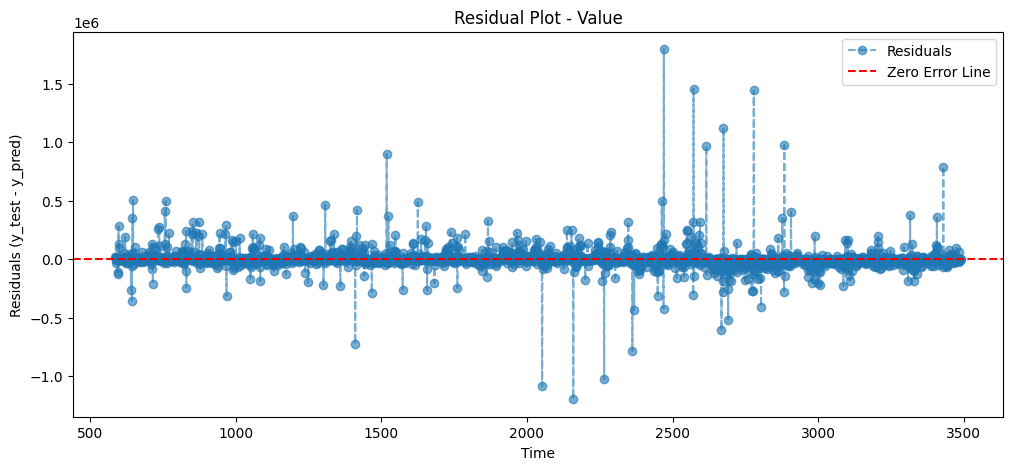

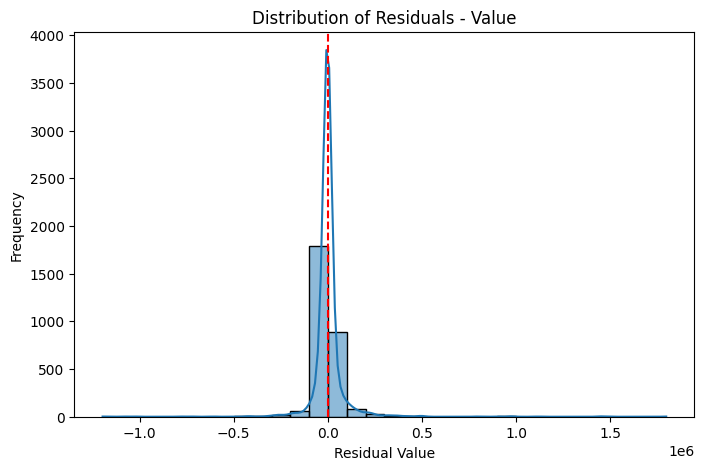

In [99]:
plt.figure(figsize=(12, 5))
plt.plot(rf_residuals_value.index, rf_residuals_value["residuals"], marker='o', linestyle='dashed', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot - Value")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(rf_residuals_value["residuals"], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals - Value")
plt.show()

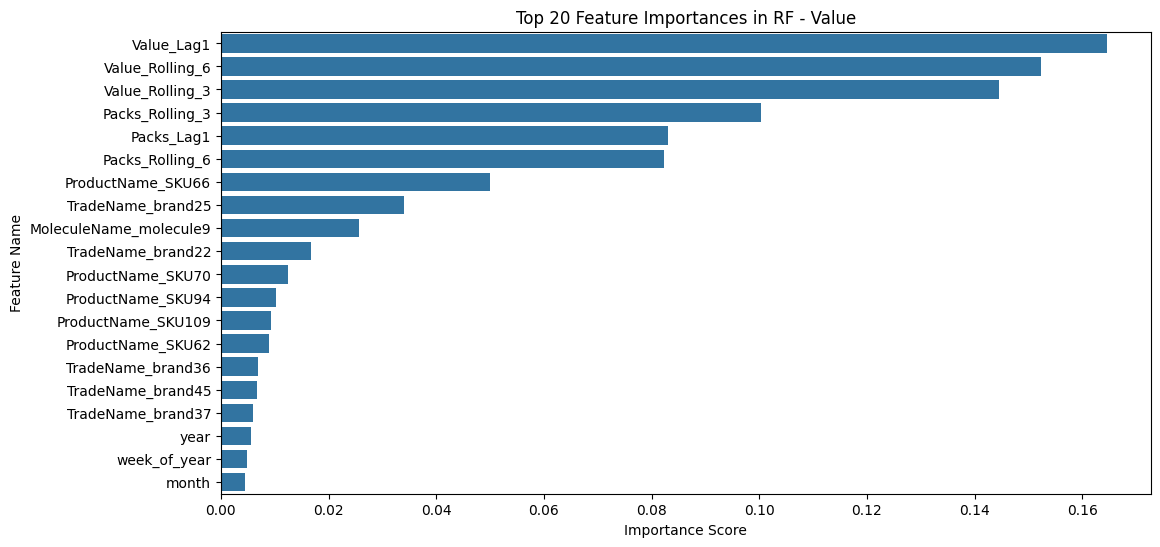

In [100]:
importances_value = rf_model_value.feature_importances_
feature_names = X.columns

feat_imp_df_value = pd.DataFrame({'Feature': feature_names, 'Importance': importances_value})
feat_imp_df_value = feat_imp_df_value.sort_values(by="Importance", ascending=False)  


plt.figure(figsize=(12, 6)) 
sns.barplot(x=feat_imp_df_value.Importance[:20], y=feat_imp_df_value.Feature[:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances in RF - Value")  
plt.show()  
   

#### Packs

In [101]:
rf_reg_packs = RandomForestRegressor(n_estimators=100, oob_score=True)
rf_model_packs, rf_mse_packs, rf_residuals_packs = evaluate_model(rf_reg_packs, X, y_packs, tscv, param_grid_rf)
print(f'Random Forest MSE for Packs: {rf_mse_packs}')

Training set size: (586, 247),  Test set size: (581, 247)
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training set size: (1167, 247),  Test set size: (581, 247)
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training set size: (1748, 247),  Test set size: (581, 247)
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training set size: (2329, 247),  Test set size: (581, 247)
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training set size: (2910, 247),  Test set size: (581, 247)
Best parameters: {'bootstrap': Tru

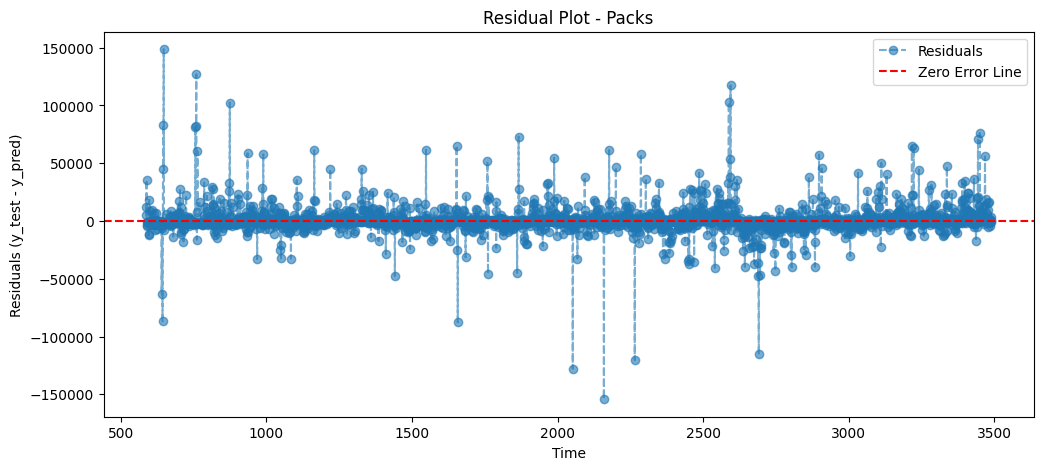

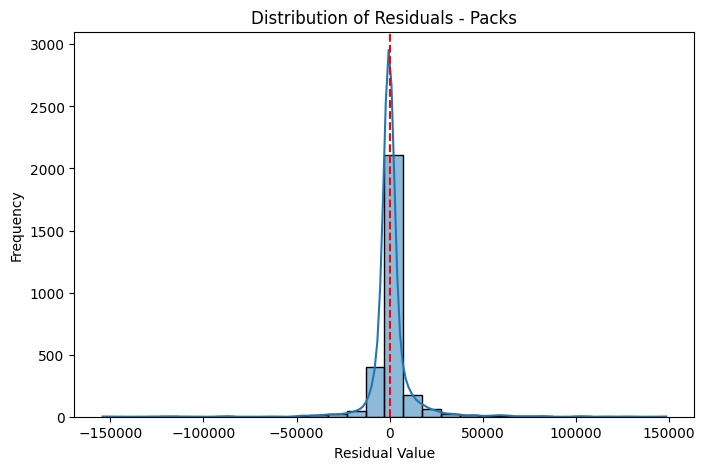

In [103]:
plt.figure(figsize=(12, 5))
plt.plot(rf_residuals_packs.index, rf_residuals_packs["residuals"], marker='o', linestyle='dashed', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot - Packs")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(rf_residuals_packs["residuals"], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")  
plt.title("Distribution of Residuals - Packs")
plt.show()

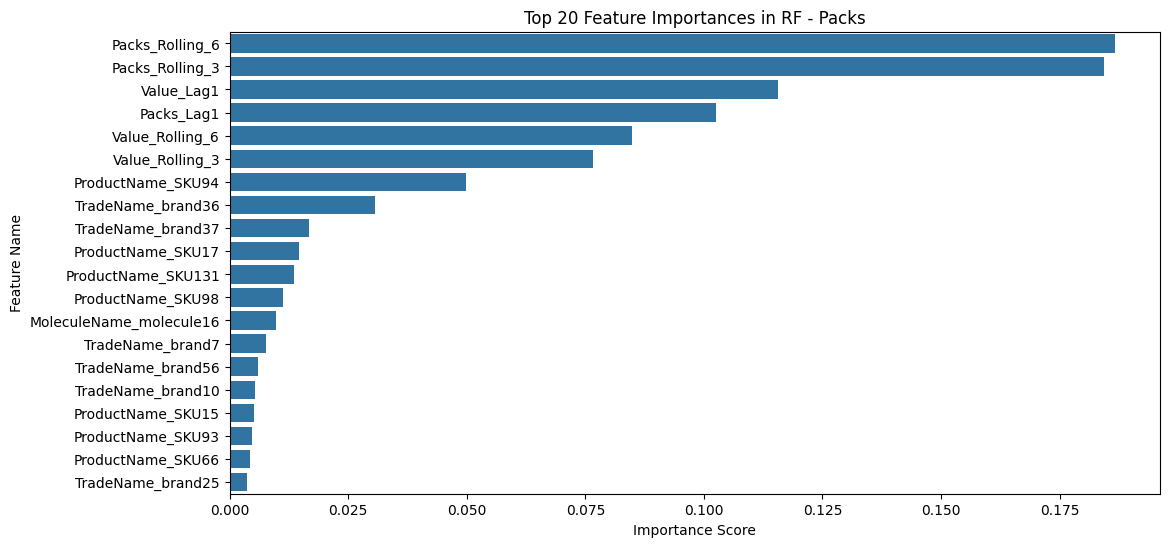

In [104]:
importances_packs = rf_model_packs.feature_importances_
feature_names = X.columns

feat_imp_df_packs = pd.DataFrame({'Feature': feature_names, 'Importance': importances_packs})
feat_imp_df_packs = feat_imp_df_packs.sort_values(by="Importance", ascending=False)  


plt.figure(figsize=(12, 6)) 
sns.barplot(x=feat_imp_df_packs.Importance[:20], y=feat_imp_df_packs.Feature[:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances in RF - Packs")  
plt.show()  
   

raining set size: (586, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training set size: (1167, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training set size: (1748, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training set size: (2329, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training set size: (2910, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean MSE:  143474801.98031405
Random Forest MSE for Packs: 143474801.98031405

### SARIMA

In [105]:
param_grid_sarima = {
    'order': [(1, 1, 1), (2,1, 1), (1, 1,2)],  
    'seasonal_order': [(1, 1, 1, 12), (0, 1, 1,12),(1, 0, 1, 12)],        
    'enforce_stationarity':[True, False],
    'enforce_invertibility': [True, False]   
}


#### Value

In [109]:
sarima_model_value = SARIMAX(y_value, order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarima_value, mse_sarima_value, residuals_sarima_value = evaluate_model(sarima_model_value, X, y_value, tscv, param_grid_sarima)
print(f'SARIMA Model MSE: {mse_sarima_value}')

c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 

Mean MSE:  119361440017.21622
SARIMA Model MSE: 119361440017.21622


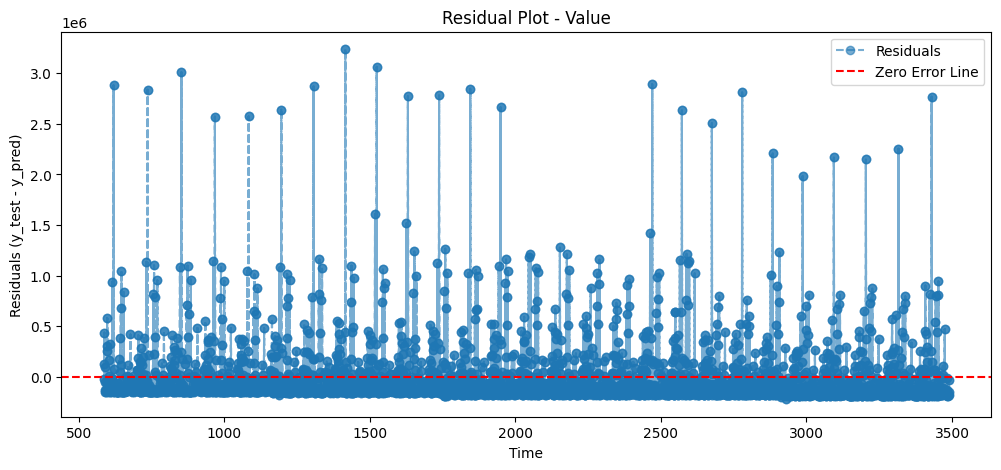

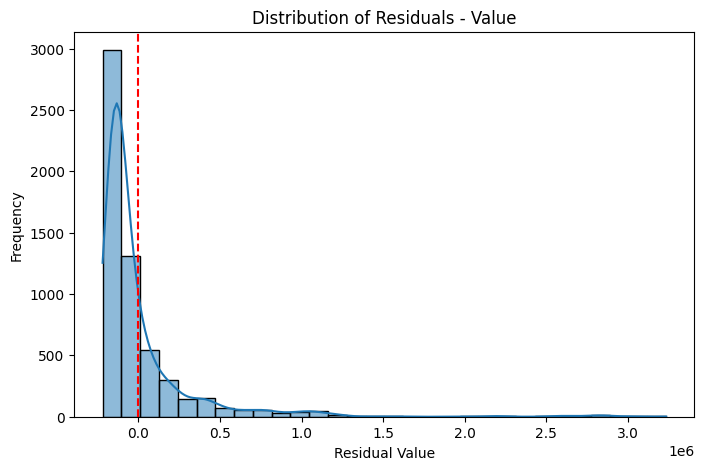

In [141]:
plt.figure(figsize=(12, 5))
plt.plot(residuals_sarima_value.index, residuals_sarima_value["residuals"], marker='o', linestyle='dashed', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot - Value")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(residuals_sarima_value["residuals"], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")  
plt.title("Distribution of Residuals - Value")
plt.show()

In [145]:
coefficients = model_sarima_value.params    

coefficients_df = pd.DataFrame(coefficients, columns=["Coefficient"])  
print(coefficients_df)  


           Coefficient
ar.L1    -2.161010e-02
ar.L2     5.324064e-02
ma.L1    -9.983253e-01
ar.S.L12 -4.804876e-01
ma.S.L12  3.851091e-01
sigma2    1.497702e+11


#### Packs

In [118]:
sarima_model_pack = SARIMAX(y_value, order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarima_pack, mse_sarima_pack, residuals_sarima_pack = evaluate_model(sarima_model_pack, X, y_packs, tscv, param_grid_sarima)
print(f'SARIMA Model MSE: {mse_sarima_pack}')

Mean MSE:  4077168100.7676954
SARIMA Model MSE: 4077168100.7676954


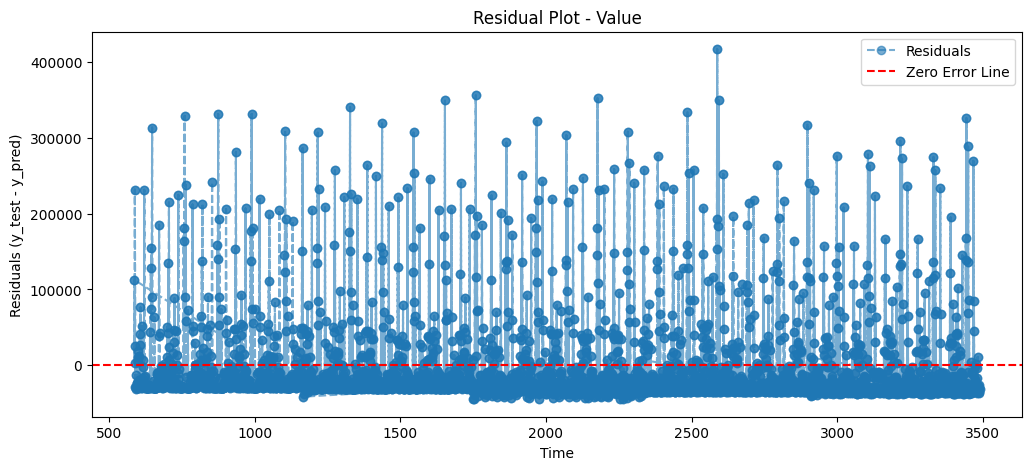

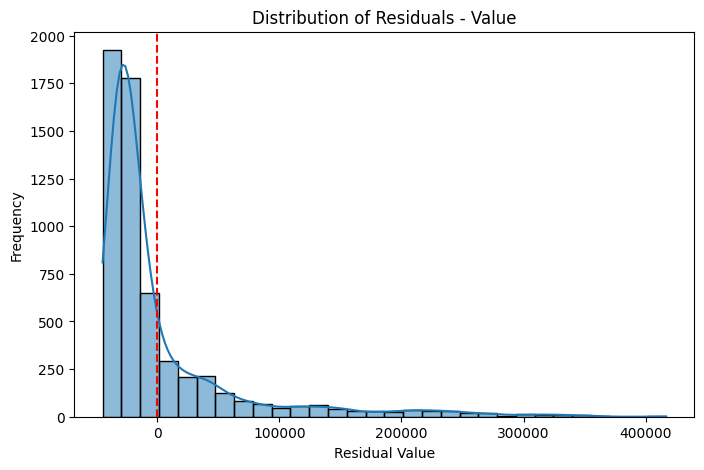

In [146]:
plt.figure(figsize=(12, 5))
plt.plot(residuals_sarima_pack.index, residuals_sarima_pack["residuals"], marker='o', linestyle='dashed', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot - Value")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(residuals_sarima_pack["residuals"], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")  
plt.title("Distribution of Residuals - Value")
plt.show()

In [ ]:
coefficients = model_sarima_pack.params    

coefficients_df = pd.DataFrame(coefficients, columns=["Coefficient"])  
print(coefficients_df)  
   

           Coefficient
ar.L1    -9.623423e-01
ma.L1    -4.487829e-02
ma.L2    -9.513486e-01
ar.S.L12  1.465418e-01
ma.S.L12 -3.139435e-01
sigma2    4.232223e+09


### Prophet

In [132]:
param_grid_prophet = {
    'growth': ['linear'], 
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1], 
    'seasonality_prior_scale': [0.1, 1, 10], 
    'seasonality_mode': ['additive', 'multiplicative'],  
}


#### Value

In [139]:
prophet_model_value = Prophet()
model_prophet_value, mse_prophet_value, residuals_prophet_value = evaluate_model(prophet_model_value, X, y_value, tscv, param_grid_prophet)
print(f'Prophet Model MSE: {mse_prophet_value}')

15:17:12 - cmdstanpy - INFO - Chain [1] start processing
15:17:12 - cmdstanpy - INFO - Chain [1] done processing
15:17:12 - cmdstanpy - INFO - Chain [1] start processing
15:17:12 - cmdstanpy - INFO - Chain [1] done processing
15:17:13 - cmdstanpy - INFO - Chain [1] start processing
15:17:13 - cmdstanpy - INFO - Chain [1] done processing
15:17:13 - cmdstanpy - INFO - Chain [1] start processing
15:17:13 - cmdstanpy - INFO - Chain [1] done processing
15:17:14 - cmdstanpy - INFO - Chain [1] start processing
15:17:14 - cmdstanpy - INFO - Chain [1] done processing
15:17:14 - cmdstanpy - INFO - Chain [1] start processing
15:17:14 - cmdstanpy - INFO - Chain [1] done processing
15:17:14 - cmdstanpy - INFO - Chain [1] start processing
15:17:15 - cmdstanpy - INFO - Chain [1] done processing
15:17:15 - cmdstanpy - INFO - Chain [1] start processing
15:17:15 - cmdstanpy - INFO - Chain [1] done processing
15:17:16 - cmdstanpy - INFO - Chain [1] start processing
15:17:16 - cmdstanpy - INFO - Chain [1]

Mean MSE:  119361755416.28036
Prophet Model MSE: 119361755416.28036


#### Packs

In [140]:
prophet_model_pack = Prophet()
model_prophet_pack, mse_prophet_pack, residuals_prophet_pack = evaluate_model(prophet_model_pack, X, y_value, tscv, param_grid_prophet)
print(f'Prophet Model MSE: {mse_prophet_pack}')

15:17:31 - cmdstanpy - INFO - Chain [1] start processing
15:17:31 - cmdstanpy - INFO - Chain [1] done processing
15:17:31 - cmdstanpy - INFO - Chain [1] start processing
15:17:32 - cmdstanpy - INFO - Chain [1] done processing
15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:32 - cmdstanpy - INFO - Chain [1] done processing
15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:32 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:34 - cmdstanpy - INFO - Chain [1] start processing
15:17:34 - cmdstanpy - INFO - Chain [1] done processing
15:17:34 - cmdstanpy - INFO - Chain [1] start processing
15:17:34 - cmdstanpy - INFO - Chain [1] done processing
15:17:35 - cmdstanpy - INFO - Chain [1] start processing
15:17:35 - cmdstanpy - INFO - Chain [1] done processing
15:17:36 - cmdstanpy - INFO - Chain [1] start processing
15:17:36 - cmdstanpy - INFO - Chain [1]

Mean MSE:  119361755416.28036
Prophet Model MSE: 119361755416.28036
